## Часть 3. Модуль распознавания шрифта.

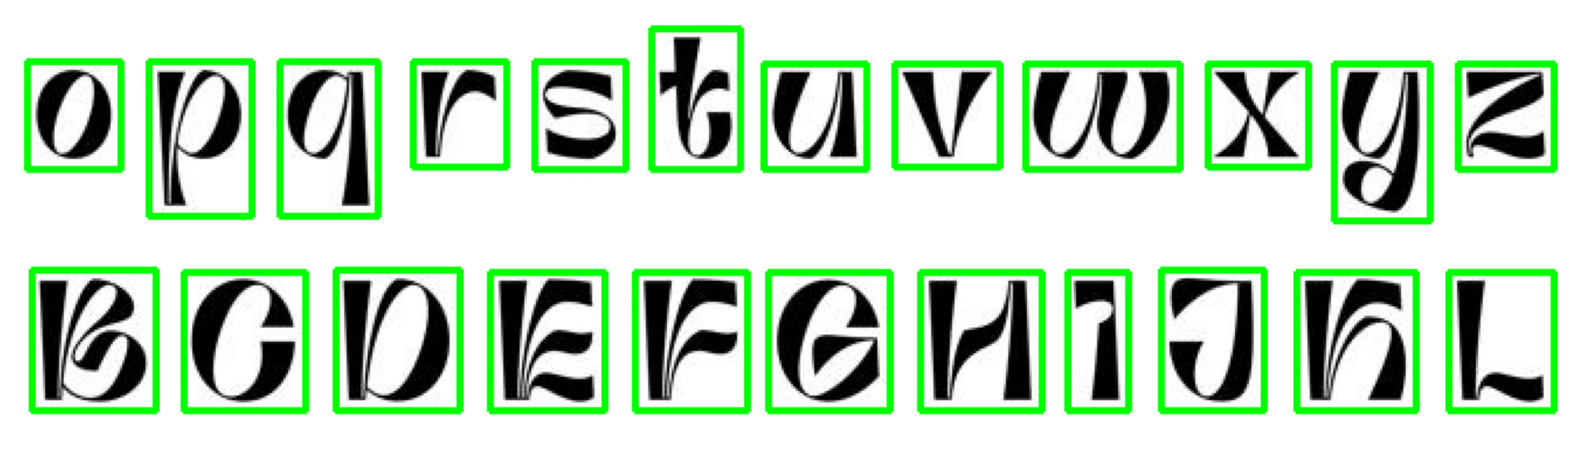

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


SystemExit: 0

C:\Users\19220\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
import sys
from PyQt6 import QtWidgets, QtCore, QtGui
import tkinter as tk
from PIL import ImageGrab, ImageTk
import numpy as np
import cv2
import tensorflow as tf
from statistics import mode
from PIL import Image, ImageDraw, ImageFilter
import matplotlib.pyplot as plt
import ctypes

scale_factor = ctypes.windll.shcore.GetScaleFactorForDevice(0)/100   #коэффициент  масштабирования экрана монитора

model = tf.keras.models.load_model('model_kvant_1.h5')

letters_new = []
predict_new = []

class MyWidget(QtWidgets.QWidget):
    def __init__(self):
        super().__init__()
        root = tk.Tk()
        screen_width = root.winfo_screenwidth()
        screen_height = root.winfo_screenheight()
        self.setGeometry(0, 0, screen_width, screen_height)
        self.setWindowTitle(' ')
        self.begin = QtCore.QPoint()
        self.end = QtCore.QPoint()
        self.setWindowOpacity(0.3)
        QtWidgets.QApplication.setOverrideCursor(
            QtGui.QCursor(QtCore.Qt.CursorShape.CrossCursor)
        )
        self.setWindowFlags(QtCore.Qt.WindowType.FramelessWindowHint)
        self.show()

    def paintEvent(self, event):
        qp = QtGui.QPainter(self)
        qp.setPen(QtGui.QPen(QtGui.QColor('black'), 3))
        qp.setBrush(QtGui.QColor(128, 128, 255, 128))
        qp.drawRect(QtCore.QRect(self.begin, self.end))

    def mousePressEvent(self, event):
        self.begin = event.pos()
        self.end = self.begin
        self.update()

    def mouseMoveEvent(self, event):
        self.end = event.pos()
        self.update()

    def mouseReleaseEvent(self, event):
        self.close()
    
        x1 = min(self.begin.x(), self.end.x())*scale_factor
        y1 = min(self.begin.y(), self.end.y())*scale_factor
        x2 = max(self.begin.x(), self.end.x())*scale_factor
        y2 = max(self.begin.y(), self.end.y())*scale_factor

        img = ImageGrab.grab(bbox=(x1, y1, x2, y2), include_layered_windows=False )
        img.save('screenshot.jpg')
        img = cv2.imdecode(np.fromfile('screenshot.jpg', dtype=np.uint8), 1)

        gray = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
        
        ret, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY) 
        img_erode = cv2.erode(thresh, np.ones((3, 3), np.uint8), iterations=3)
        contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
        sharp_filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        img_sharpen = cv2.filter2D(thresh, ddepth=-1, kernel=sharp_filter)    
        output = img.copy()

        out_size=256
        letters = []
        i = 0
        for idx, contour in enumerate(contours):
            (x, y, w, h) = cv2.boundingRect(contour)
            if hierarchy[0][idx][3] == 0:
                cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
                letter_crop = img_sharpen[y:y + h, x:x + w]
        
                size_max = max(w, h)
                letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
                if w > h:
        
                    y_pos = size_max//2 - h//2
                    letter_square[y_pos:y_pos + h, 0:w] = letter_crop
                elif w < h:
                    x_pos = size_max//2 - w//2
                    letter_square[0:h, x_pos:x_pos + w] = letter_crop
                else:
                    letter_square = letter_crop
    
                i += 1
                letter_square = cv2.filter2D(letter_square, ddepth=-1, kernel=sharp_filter)
                letters.append((x, w, cv2.resize(letter_square, (out_size, out_size), interpolation=cv2.INTER_AREA)))
                     
        fig = plt.figure(figsize=(20, 10))
        plt.imshow(output, cmap='gray')
        plt.axis('off')
        plt.show()                       
        letters.sort(key=lambda x: x[0], reverse=False)

        for i in range(0, len(letters)): 
            
            img = letters[i][2]
            img = Image.fromarray(img, mode=None) 
            fixed_len = 256
                
            draw = ImageDraw.Draw(img) 
            width, height = img.size
            width = img.size[0] 
            height = img.size[1] 
            if width >= height:
                ratio = (fixed_len+1)/float(img.size[0])
                new_height = int(ratio * img.size[1])
                new_size = (fixed_len+1, new_height)
            else:
                ratio = (fixed_len+1)/float(img.size[1])
                new_width = int(ratio * img.size[0])
                new_size = (new_width, fixed_len+1)
            new_image = img.resize(new_size)
            
            sharp_image = new_image.filter(ImageFilter.SHARPEN)
            image = sharp_image.resize((fixed_len, fixed_len))
            
            draw = ImageDraw.Draw(image) 
            width, height = image.size
            width = image.size[0] 
            height = image.size[1] 	
            pix = image.load() 
        
            factor = 100 
            for k in range(width):
                for j in range(height):
                    a = pix[k, j]
                    S = a
                    if S > factor:
                        a = 255
                    else:
                        a = 0 
                    draw.point((k, j), a )
            del draw
            letters_new.append(image)

        emnist_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

        if len(letters_new) > 0:
            for img in letters_new:
                img = np.array(img)/255
                img = np.expand_dims(img, axis=0)
                predict = model.predict(img)
                result = np.argmax(predict, axis=1)
                num = emnist_labels[result[0]]
                predict_new.append(num)

            def most_common(List):
                return(mode(List))
    
            count = most_common(predict_new)
        
        if len(predict_new) == 0:
            count = 16     
            if count > len(predict_new)/2:
                count = count
            else:
                count = 16
        
        font_name = cv2.imdecode(np.fromfile('Font real/'+str(count)+'.jpg', dtype=np.uint8), 1)
         
        cv2.imshow('The font of the sample text', font_name)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

if __name__ == '__main__':
    app = QtWidgets.QApplication(sys.argv)
    window = MyWidget()
    window.show()
    app.aboutToQuit.connect(app.deleteLater)
    sys.exit(app.exec())

tk.mainloop()